# Data Preparation

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor, KNNBasic

# from sklearn.model_selection import train_test_split

plt.style.use('fast')
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
transactions = pd.read_csv('Data/out.zip')
transactions.head(3)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1


In [4]:
transactions.shape

(671674, 8)

Transactions data description:

- t_dat : A unique identifier of every customer
- customer_id : A unique identifier of every customer (in customers table)
- article_id : A unique identifier of every article (in articles table)
- price : Price of purchase
- sales_channel_id : 1 or 2

### Surprise Data & Split 

In [5]:
# Without Negative samples
# Instantiate reader the same convention as a sklearn class
reader = Reader(rating_scale = (0,1))
# Load user_data from imported dataframe specifiyng which columns to use
customer_data = Dataset.load_from_df(transactions[['customer_id', 'article_id', 'bought']], reader)

In [6]:
type(customer_data)

surprise.dataset.DatasetAutoFolds

In [7]:
# # Instantiate reader the same convention as a sklearn class
# reader = Reader(rating_scale = (0,1))
# # Load user_data from imported dataframe specifiyng which columns to use
# customer_data = Dataset.load_from_df(total_transactions[['customer_id', 'article_id', 'bought']], reader)

In [8]:
# # without negative samples
# #use sklearn for model selection/choosing 
# train, test = train_test_split(transactions, random_state=42)

# reader = Reader(rating_scale=(0, 1))
# train_data = Dataset.load_from_df(train[['customer_id', 'article_id', 'bought']], reader)
# test_data = Dataset.load_from_df(test[['customer_id', 'article_id', 'bought']], reader)

# train_data2 = train_data.build_full_trainset()
# test_data2 = test_data.build_full_trainset().build_testset()

In [9]:
# #use sklearn for model selection/choosing 
# train, test = train_test_split(total_transactions, random_state=42)

# reader = Reader(rating_scale=(0, 1))
# train_data = Dataset.load_from_df(train[['customer_id', 'article_id', 'bought']], reader)
# test_data = Dataset.load_from_df(test[['customer_id', 'article_id', 'bought']], reader)

# train_data2 = train_data.build_full_trainset()
# test_data2 = test_data.build_full_trainset().build_testset()

In [10]:
# Perform an appropriate split for the recommendation models
trainset, testset = train_test_split(customer_data, test_size=0.2, random_state=42)

In [11]:
#How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  172712 

Number of items:  9225 



## Modeling

### Baselines without cross validation

In [12]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 0.0000


In [13]:
# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.0000


### Baseline with Cross Validation train test split

In [14]:
# dummy_model = NormalPredictor()
# #cross_validate(dummy_model, train_data, measures=['RMSE'], cv=5, verbose=True)

# predictions = dummy_model.fit(trainset).test(testset)
# baseline_rsme = accuracy.rmse(predictions)
# baseline_rsme

In [15]:
# dummy_model2 = BaselineOnly()
# #cross_validate(dummy_model, train_data, measures=['RMSE'], cv=5, verbose=True)

# predictions = dummy_model2.fit(trainset).test(testset)
# baseline_rsme2 = accuracy.rmse(predictions)
# baseline_rsme2

### SVD

In [16]:
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
svd_simple_predictions = accuracy.rmse(svd_predictions)
svd_simple_predictions

RMSE: 0.0458


0.04582266169604622

In [17]:
svd_model.predict('0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', 902802002)

Prediction(uid='0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', iid=902802002, r_ui=None, est=0.9030224169888206, details={'was_impossible': False})

In [18]:
transactions.loc[(transactions['customer_id'] == '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2') & 
                 (transactions['article_id'] == 902802002)]

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought


In [19]:
param_grid = {'n_factors':[10,50],'n_epochs': [5, 15], 'lr_all': [0.002,0.01],
             'reg_all': [0.2,0.6]}
gs_model_SVD1 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD1.fit(customer_data)

gs_model_SVD1.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:  7.1min finished


{'rmse': {'n_factors': 10, 'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.6}}

explain

In [20]:
param_grid2 = {'n_factors':[5,10],'n_epochs': [15, 50], 'lr_all': [0.001, 0.01],
             'reg_all': [0.6, 0.8]}
gs_model_SVD2 = GridSearchCV(SVD,param_grid=param_grid2,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD2.fit(customer_data)

gs_model_SVD2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed: 12.6min finished


{'rmse': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.8}}

explain

In [21]:
param_grid3 = {'n_factors':[5],'n_epochs': [50, 100], 'lr_all': [0.1, 0.2],
             'reg_all': [0.8, 0.9]}
gs_model_SVD3 = GridSearchCV(SVD,param_grid=param_grid3,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD3.fit(customer_data)

gs_model_SVD3.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  36 out of  40 | elapsed: 11.5min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed: 11.7min finished


{'rmse': {'n_factors': 5, 'n_epochs': 100, 'lr_all': 0.2, 'reg_all': 0.9}}

In [22]:
param_grid4 = {'n_factors':[5],'n_epochs': [100, 150], 'lr_all': [0.2, 0.3],
             'reg_all': [0.7, 0.8]}
gs_model_SVD4 = GridSearchCV(SVD,param_grid=param_grid4,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD4.fit(customer_data)

gs_model_SVD4.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done  36 out of  40 | elapsed: 17.8min remaining:  2.0min
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed: 18.2min finished


{'rmse': {'n_factors': 5, 'n_epochs': 100, 'lr_all': 0.2, 'reg_all': 0.8}}

We find the best parameters for SVD modeling are - 
- n_factors : 3
- n_epochs : 100
- lr_all :0.2
- reg_all : 0.8

Now we build a model with the best parameters and test it on our testset.

In [23]:
svd_model2 = SVD(n_factors= 5, n_epochs= 100, lr_all = 0.2, reg_all = 0.7)
svd_model2.fit(trainset)
svd_predictions2 = svd_model2.test(testset)
svd_tuned_predictions = accuracy.rmse(svd_predictions2)
svd_tuned_predictions

RMSE: 0.0000


4.750979905266584e-18

### NFM 

Now, we explore the `Non-negative Matrix Factorization (NMF)` from the `suprise` library. The only difference between this algorithm and the previous algorithm SVD is that in NMF, a specific step size is set for the stochastic gradient descent process of regularization. This is done to ensure that all user and item factors are kept positive. While this model can be prone to over-fitting, this can be mitigated with steps to reduce the dimensionality of our data/factors.

In [24]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)
nmf_simple_predictions = accuracy.rmse(nmf_predictions)
nmf_simple_predictions

RMSE: 0.0680


0.06801338992219715

In [26]:
param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
gs_model_NFM = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM.fit(customer_data)

gs_model_NFM.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-2)]: Done  42 out of  45 | elapsed: 14.9min remaining:  1.1min
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed: 15.9min finished


{'rmse': {'n_factors': 10, 'n_epochs': 75}}

explain

In [27]:
param_grid = {'n_factors':[10],'n_epochs': [75, 100]}
gs_model_NFM2 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM2.fit(customer_data)

gs_model_NFM2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.2min
[Parallel(n_jobs=-2)]: Done   6 out of  10 | elapsed:  3.9min remaining:  2.6min
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:  5.3min finished


{'rmse': {'n_factors': 10, 'n_epochs': 100}}

Explain

We find the best parameters for NMF modeling are - 
- n_factors : 10
- n_epochs : 100

Now we build a model with the best parameters and test it on our testset.

In [28]:
nmf_model2 = NMF(n_factors = 10, n_epochs = 100)
nmf_model2.fit(trainset)
nmf_predictions2 = nmf_model2.test(testset)
nmf_tuned_predictions = accuracy.rmse(nmf_predictions2)

nmf_tuned_predictions

RMSE: 0.0583


0.05826769236768949

## SVD ++ 

For a final look at models from the `surprise` library, I wanted to try and utilize the SVD++ algorithm, again, very similar to SVD. The difference is that SVD++ attempts to add an extension onto the base SVD that uses implicit rating as well as explicit. In other words it infers the action of rating an item as a latent factor regardless of the rating value given to the item while also factoring the actual rating value. I thought this might further improve the RMSE by taking into account reviewers who have rated a large number of eBooks. Please note that this Grid Search will take a very long time to run.

In [29]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp()
SVDpp_model.fit(trainset)
SVDpp_predictions = SVDpp_model.test(testset)
svdpp_simple_predictions = accuracy.rmse(SVDpp_predictions)

svdpp_simple_predictions

RMSE: 0.0207


0.02065658072120093

In [30]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[1, 5], 'n_epochs':[25, 50], 'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model.fit(customer_data)

svdpp_gs_model.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done  16 out of  24 | elapsed: 11.3min remaining:  5.6min
[Parallel(n_jobs=-2)]: Done  21 out of  24 | elapsed: 14.5min remaining:  2.1min
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 15.8min finished


{'rmse': {'n_factors': 1, 'n_epochs': 50, 'reg_all': 0.05}}

explain

In [31]:
# New dictionary for SVD++
svdpp_param_grid2 = {'n_factors':[1], 'n_epochs':[50, 100], 'reg_all':[0.05, 0.1]}
svdpp_gs_model2 = GridSearchCV(SVDpp, param_grid=svdpp_param_grid2, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model2.fit(customer_data)

svdpp_gs_model2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  12 | elapsed:  5.0min remaining: 25.2min
[Parallel(n_jobs=-2)]: Done   5 out of  12 | elapsed:  5.3min remaining:  7.4min
[Parallel(n_jobs=-2)]: Done   8 out of  12 | elapsed: 14.7min remaining:  7.4min
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed: 15.0min finished


{'rmse': {'n_factors': 1, 'n_epochs': 100, 'reg_all': 0.1}}

We find the best parameters for SVD ++ modeling are - 
- n_factors : 1
- n_epochs : 100
- reg_all : 0.1

Now we build a model with the best parameters and test it on our testset.

In [32]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model2 = SVDpp(n_factors=1, n_epochs=100, reg_all=0.1)
SVDpp_model2.fit(trainset)
SVDpp_predictions2 = SVDpp_model2.test(testset)
svdpp_tuned_predictions = accuracy.rmse(SVDpp_predictions2)

svdpp_tuned_predictions

RMSE: 0.0009


0.0008559735015271697

## Model Performance

In [ ]:
# # just to code ahead! 
# svd_simple_predictions = 0.04
# svd_tuned_predictions = 5.246579612895187e-19
# nmf_simple_predictions = 0.0676
# nmf_tuned_predictions = 0.0583
# svdpp_simple_predictions = 0.0207
# svdpp_tuned_predictions = 0.0207

In [34]:
X = ['Baseline', 'SVD Basic', 'SVD Tuned', 'NMF Basic', 'NMF tuned', 'SVD ++ Basic', 'SVD ++ Tuned']
y = [baseline_only, svd_simple_predictions, svd_tuned_predictions, nmf_simple_predictions, nmf_tuned_predictions, svdpp_simple_predictions, svdpp_tuned_predictions]

Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

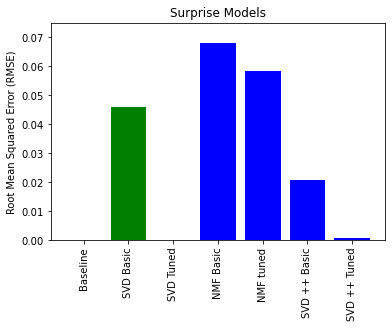

In [38]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'green', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(rotation=90)
plt.ylim(0, .075)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
# plt.savefig('Images/Model_bar.png', dpi=300, bbox_inches='tight');

# Recommendation Function

### Building

##### Final Model

In [39]:
# Using Surprise a full trainset incorporating all data can be built and fit to the model in order to make full predictions
trainset_full = customer_data.build_full_trainset()

In [42]:
final_model = SVD(n_factors= 5, n_epochs= 100, lr_all = 0.2, reg_all = 0.7)
final_model.fit(trainset_full)

In [43]:
# The model is pickled and saved into the Model folder in the repository so it can used in the app.py file
pickle.dump(final_model, open('Model/collaborative_model.sav', 'wb'))

In [44]:
transactions.tail(10)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
671664,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,651591001,0.032186,2,2020-09-22,2020-09-22,1
671665,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,864339003,0.022017,2,2020-09-22,2020-09-22,1
671666,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,938667001,0.010153,2,2020-09-22,2020-09-22,1
671667,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,762846006,0.025407,2,2020-09-22,2020-09-22,1
671668,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,762846027,0.025407,2,2020-09-22,2020-09-22,1
671669,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,914404001,0.042356,2,2020-09-22,2020-09-22,1
671670,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471041,0.033881,2,2020-09-22,2020-09-22,1
671671,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471038,0.033881,2,2020-09-22,2020-09-22,1
671672,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2,2020-09-22,2020-09-22,1
671673,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,740519002,0.045746,2,2020-09-22,2020-09-22,1


Start from here... 
- we have to load the articles df here as meta data with article id as the index 
- build function

In [ ]:
meta_articles = pd.read_csv('Data/ata/art')

In [ ]:
svd_model2.predict('ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1dfd2f8586a5ce3ce8bf4', 651591001)

In [ ]:
transactions.loc[(transactions['customer_id'] == 'ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1dfd2f8586a5ce3ce8bf4') & 
                  (transactions['article_id'] == 651591001)]

In [ ]:
import difflib
import random

def get_articles_id(book_title, metadata):
    
    """
    Gets the article ID for a item based on the closest match in the metadata dataframe.
    """
    
    existing_titles = list(metadata['title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['title'] == closest_titles[0]]['id'].values[0]
    return book_id

def get_book_info(book_id, metadata):
    
    """
    Returns some basic information about a book given the book id and the metadata dataframe.
    """
    
    book_info = metadata[metadata['id'] == book_id][['id', 'isbn', 
                                                    'authors', 'title', 'original_title']]
    return book_info.to_dict(orient='records')

def predict_review(user_id, book_title, model, metadata):
    
    """
    Predicts the review (on a scale of 1-5) that a user would assign to a specific book. 
    """
    
    book_id = get_book_id(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    """
    Generates a book recommendation for a user based on a rating threshold. Only
    books with a predicted rating at or above the threshold will be recommended
    """
    
    book_titles = list(metadata['title'].values)
    random.shuffle(book_titles)
    
    for book_title in book_titles:
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
            book_id = get_book_id(book_title, metadata)
            return get_book_info(book_id, metadata)
